# Training an RL agent on Atari games using DEEP Q-Learning

***Name - Umesh Karthikeya\
Roll no - 22b0913***

Let us start by installing necessary packages\
We need to install ***gym[box2d]*** which contains environments of many atari games\
For our lunar lander we need to instal that

In [1]:
! pip install swig > /dev/null 2>&1
! pip install gym[box2d] > /dev/null 2>&1

The system cannot find the path specified.
The system cannot find the path specified.


**Import libraries**

In [1]:
import gymnasium as gym # for OpenAI gym environments
import torch # for nn
import numpy as np # for linear algebra
import random # for generating random numbers
from collections import deque # explained later

**Let us try to train Lunar Lander RL**

In [30]:
# This is just sample code from Documentation to check imports working or not
# link - https://gymnasium.farama.org/

env = gym.make("LunarLander-v2", render_mode="human")
observation, _ = env.reset(seed=42)
for x in range(1000):
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        observation, info = env.reset()
    if x%100==0:
        print(reward)


env.close()

1.1449803922348565
-0.1816319229251053
-2.848917571753134
1.2038122798927702
-4.644114022483762
-2.186665228469451
-3.233723149349191
-16.642167421165794
-1.6665692543997466
-1.0329087436720943


**Observation**\
we can see that lander is just moving randomly and unable to land on the expected region, let's apply RL and make lander perfectly between the poles

**Let's understand the environment**\
This information is available in the documentation\
https://gymnasium.farama.org/environments/box2d/lunar_lander/ 

| Feature Category  | Details                                |
|-------------------|----------------------------------------|
| Action Space      | Discrete(4)                            |
| Observation Shape | (8,)                                   |
| Observation High  | [1.5 1.5 5. 5. 3.14 5. 1. 1. ]         |
| Observation Low   | [-1.5 -1.5 -5. -5. -3.14 -5. -0. -0. ] |

**Action Space**\
Here we have 4 discrete actions

| Action | Action Result          |
|--------|------------------------|
|   0    | lander do nothing      |
|--------|------------------------|
|   1    | Activate left engine   |
|--------|------------------------|
|   2    | Activate main engine   |
|--------|------------------------|
|   3    | Activate right engine  |

**Observation Shape**\
The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear velocities in `x` & `y`, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Rewards**\
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

> is increased/decreased the closer/further the lander is to the landing pad.

> is increased/decreased the slower/faster the lander is moving.

> is decreased the more the lander is tilted (angle not horizontal).

> is increased by 10 points for each leg that is in contact with the ground.

> is decreased by 0.03 points each frame a side engine is firing.

> is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

**Starting State**\
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

**Episode Termination**\
The episode finishes if:

> the lander crashes (the lander body gets in contact with the moon);

> the lander gets outside of the viewport (x coordinate is greater than 1);

> the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:

**Let us write a function that is used to run a full episode for a agent, env and seed**\
we will be using this function throughout the this file hence I decleared it here

In [31]:
def episode_play(agent, env, seed=11):
    score = 0
    state, _ = env.reset(seed=seed)
    
    is_done = False
    while not is_done:
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        is_done = terminated
        is_done = is_done or truncated
        

**Lets get used to the game**\
We shall implement a class that will just on main engine when y is less than 1

In [32]:
class test_game:
    # test_game class will just on main engine if y is less than 0.5
    # we can exepct when we run our lander on this it should never fall down..
    def act(self, state):
        if state[1] < 1: # if y < 1
            return 2 # activate main engine
        else:
            return 0 # do nothing
#     pass

In [35]:
# Let us use previous funciton 

env = gym.make('LunarLander-v2', render_mode="human")
agent = test_game()
episode_play(agent=agent, env=env)
env.close()

**Observation**\
Yup our function is working let's proceed to main code\
And we can see that as expected out lander is not landing on the moon or planet

To address this issue let's use **Reinforcement Learning**

## Explination of DQN Algo
1. We will be implementing our DQN algoithm with two neural networks **Online_net** and **Target_net**. These will be using weights to predict **Q-value** from given current_state, taken_action.
2. So basically intially I will assign same weights to both the neural networks
3. Then I will train **Online_net** and store episodes after some episodes into **Target_net**
4. We will be using **epsilon** as exploration probability i.e, if we have a random probability of **epsilon** then explore or else explot.
5. We will be using **StorageBuffer** to store *current_state, taken_action, reward_obtained, next_state, done (episode done or not)*
6. Using the stored information in *StorageBuffer* when we have sufficient information we will be training our *online_net* neural network
7. For every transition calculate y (Q-value)
8. y = reward if episodes ended at this step or else it will be $y = r + \gamma \max_{a' \in A} \hat{Q}(s', a')$ where $\hat{Q}(s', a')$ represents *target_net* neural network and $s'$ and $a'$ are state and action respectively.
9. After training sufficient episodes we will be updating *target_net*
10. We will be using MSE oss function
11. Use Adam optimization algo descent for minimize loss


**Few notes**

> We can't use Tabular methods as they are limited to discrete observational spaces\
> Our observation space is not discrete as we need to deal with continuous 8 variables as mentioned above\
> So we will be using `neural network Q-function approximator`

In [2]:
# let us define a neural network for our DQN algorithm
# This will be a normal neural network feed forward in consise with two hidden layers

class DQN_NN(torch.nn.Module):
    
    def __init__(self, state_size = 8, action_size = 4, hidden_size1=64, hidden_size2=64):
        super(DQN_NN, self).__init__()
        self.layera = torch.nn.Linear(state_size, hidden_size1)
        self.layerb = torch.nn.Linear(hidden_size1, hidden_size1)
#         self.layerc = torch.nn.Linear(hidden_size1, hidden_size2)
#         self.layerd = torch.nn.Linear(hidden_size2, hidden_size2)
# reduced layers to reduce computational time
        self.layere = torch.nn.Linear(hidden_size1, action_size)
    
    def forward(self, state):
        x = torch.relu(self.layera(state))
        x = torch.relu(self.layerb(x))
#         x = torch.relu(self.layerc(x))
#         x = torch.relu(self.layerd(x))
        return self.layere(x)

**Defining a class for out buffer so that it will be easier to use**

*Notes*
> To implement our algorithm efficiently let us use **deque** data structure\
> Benifits of using deque are:
>> We can remove elements from start or end in O(1) time complexity where as it takes O(n) time complexity for a list to do the same task.\
>> We can use it set a maximum size. As once maximum size is reached and if another element is pushed the very first element will be popped autometically ensuring out buffer has latest information 

In [3]:
class StorageBuffer:
    def __init__(self, buffer_size=10000):
        # intialize our buffer with required size
        self.buffer = deque(maxlen=buffer_size)
        
    def sample(self, batch_size):
        # Send batches of training data
        states, actions, rewards, nxt_state, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(nxt_state), dones
    
    def push(self, state, action, reward, nxt_state, done):
        # just pushing data into our storage buffer
        self.buffer.append((state, action, reward, nxt_state, done))
    
    def is_full(self, buffer_size=10000):
        # function to check whether our StorageBuffer Full or not
        return self.length() == buffer_size
    
    def length(self):
        # just for giving length
        return len(self.buffer)

    
    

### Our DQN Agent

We can try with different DQN algorithms and let us define our 1st class as DQNAgent1

In [4]:
class DQNAgent1:
    def __init__(self, state_size=8, action_size=4, hidden_size1=64, hidden_size2=64, 
                 buffer_size=10000, batch_size=64, mu=1e-3, gamma=0.99):
        # Intializing two neuaral networks online and target
        self.online_net = DQN_NN(state_size, action_size, hidden_size1, hidden_size2)
        self.target_net = DQN_NN(state_size, action_size, hidden_size1, hidden_size2)
        
        # Few constants
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        
        # for optimization
        # torch.optim.Adam - This is a class in PyTorch that implements the Adam optimization algorithm
        # Adam algo = extension od SGD
        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=mu)

        # memoruy from out storage class
        self.memory = StorageBuffer(buffer_size)
        
        # let us use same weigths 
        self.target_net.load_state_dict(self.online_net.state_dict())
    
    def step(self, state, action, reward, nxt_state, done):
        # first push into our buffer memoru
        self.memory.push(state, action, reward, nxt_state, done)
        
        if len(self.memory.buffer) >= self.batch_size:
            self.update()
            
    def act(self, state, epsilon=0):
        # we will act to normalize between explotation and exploration
        if random.random() > epsilon: # if random probability > eps then explot
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.online_net.eval()
            
            with torch.no_grad():
                action_values = self.online_net(state)
            
            self.online_net.train()
            return np.argmax(action_values.data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def update(self):
        # Get states, actions, rewards, nxt_states, done used for training online_net
        states, actions, rewards, nxt_states, dones = self.memory.sample(self.batch_size)
        
        # for nn training we need torch tensors 
        states = torch.from_numpy(states).float() 
        actions = torch.from_numpy(np.array(actions)).long() 
        rewards = torch.from_numpy(np.array(rewards)).float() 
        next_states = torch.from_numpy(nxt_states).float()
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float()
        
        # getting q values
        # gather used for dim reduction and unsqueeze and squeeze will be used for dimensions
        q_true = self.online_net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # get next q values
        # detached_tensor will not have its operations tracked for gradient computation during backpropagation. Essentially, it stops the gradient from flowing further backward.
        next_q_values = self.target_net(next_states).max(1)[0].detach()
#         next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)
        
        # expected qs
        # predicting on not dones
        q_pred = rewards + self.gamma*next_q_values*(1-dones)
        
        # loss
        loss = torch.nn.MSELoss()(q_true, q_pred)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target(self):
        # load onto target_net
        self.target_net.load_state_dict(self.online_net.state_dict())

**Lets train**

In [5]:

def train(agent, env, episodes_num=2000, eps_start=1.0, eps_end=0.01, eps_dec=0.995, target_update=10):
    
    scores = [] # we will be storing scores
    scores_window = deque(maxlen=100) # just for output purpose
    eps = eps_start
    
    for i_episode in range(1, episodes_num + 1):

        state, _ = env.reset()
        score = 0

        done = False
        while not done:
            action = agent.act(state, eps)
            nxt_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, nxt_state, done)
            state = nxt_state
            score += reward

        scores_window.append(score)
        scores.append(score)

        eps = max(eps_end, eps_dec*eps) # update eps

        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        if i_episode % target_update == 0:
            agent.update_target()

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))                

        if i_episode % 100 == 0 and np.mean(scores_window) >= 240: # 200 will be fine
            print("breaking here")
            break    

    return scores

*hope it works*

In [17]:
# Make an environment
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [18]:
agent = DQNAgent1(state_size, action_size)

In [19]:
scores = train(agent, env)

Episode 100	Average Score: -126.16
Episode 200	Average Score: -58.686
Episode 300	Average Score: -14.61
Episode 400	Average Score: 15.614
Episode 500	Average Score: 87.69
Episode 600	Average Score: 103.25
Episode 700	Average Score: 106.49
Episode 800	Average Score: 82.209
Episode 900	Average Score: 192.41
Episode 1000	Average Score: 226.92
Episode 1100	Average Score: 182.20
Episode 1200	Average Score: 206.08
Episode 1300	Average Score: 166.35
Episode 1400	Average Score: 136.76
Episode 1500	Average Score: 247.79
breaking here


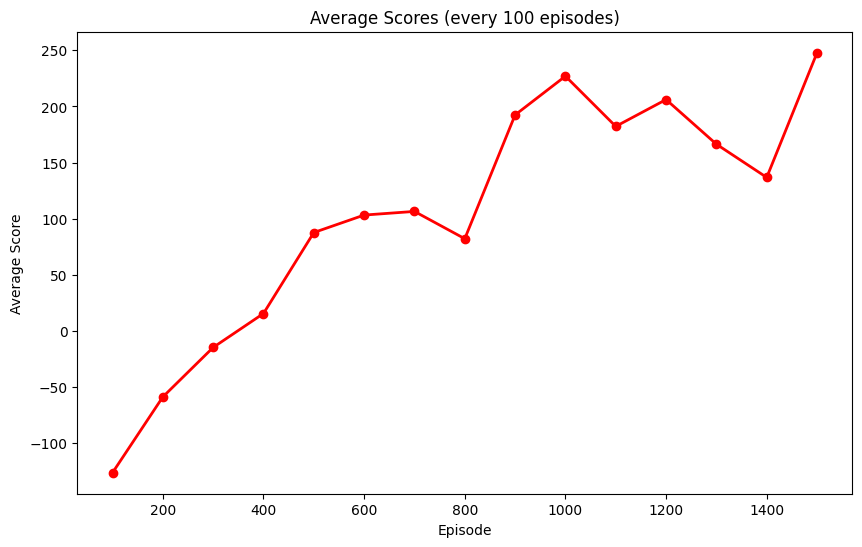

In [20]:
import matplotlib.pyplot as plt
num_intervals = len(scores) // 100
average_scores = [np.mean(scores[i*100:(i+1)*100]) for i in range(num_intervals)]
plt.figure(figsize=(10, 6))
plt.plot(np.arange(100, len(scores)+1, 100), average_scores, marker='o', color='r', linestyle='-', linewidth=2)
plt.title('Average Scores (every 100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.show()

In [21]:
import pickle
with open("agent_lunar.pkl", "wb") as f:
    pickle.dump(agent, f)

**notes**
> Increased learning rate for faster compution\
> Both increased and decreased number of layers for better output\
> When I decreased i got better outputs... with less number of episodes

In [6]:
import pickle
file_path = "E:/Umesh/extracted_features/agent_lunar.pkl"
with open(file_path, "rb") as f:
    agent = pickle.load(f)

In [10]:
env = gym.make('LunarLander-v2', render_mode="human")

def play_DQN_episode(env, agent):
    score = 0
    state, _ = env.reset(seed=42)
    
    while True:
        # eps=0 for predictions
        action = agent.act(state, 0)
        state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated

        score += reward

        # End the episode if done
        if done:
            break 
    env.close()
    return score
 
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Score obtained: 247.8560208233823


In [ ]:
# scores